In [1]:

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load Dataset

In [2]:
# Load object Detection dataset

dataset = kagglehub.dataset_download('gjeevanm/object-detection-dataset')

train_path = dataset + '/tusimple_preprocessed/training'


In [3]:
# Create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


In [4]:
# Current Directory
current_dir = os.getcwd()
working_dir = os.path.join(current_dir, 'lane_detection')  
image_dir = os.path.join(working_dir, 'images')
os.makedirs(working_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)


In [5]:
# Save few files to local
images, labels = next(images_set)
np.save(working_dir + '/images.npy', images)
np.save(working_dir + '/labels.npy', labels)

# folder


# EDA

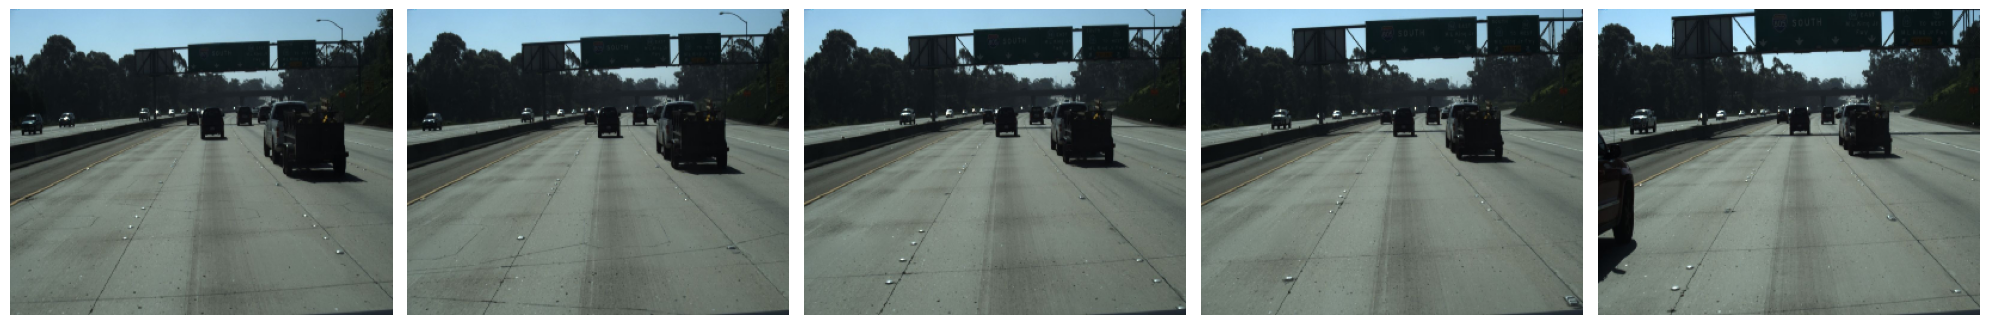

In [6]:
images, labels = next(images_set)

# Normalize images
if images.max() > 1.0:
    images = images / 255.0

# Display the images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the first 5 images in the batch
plot_images(images[:5])

# Image Shapes

In [7]:
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of images: (64, 256, 320, 3)
Shape of labels: (64,)


In [8]:
# Save 5 images to local
for i in range(5):
    cv2.imwrite(image_dir + f'/image_{i}.jpg', images[i])

# Image Statistics

In [9]:
def display_image_statistics(images):
    print(f"Min pixel value: {images.min()}")
    print(f"Max pixel value: {images.max()}")
    print(f"Mean pixel value: {images.mean()}")
    print(f"Standard deviation of pixel values: {images.std()}")

display_image_statistics(images)

Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.3677613437175751
Standard deviation of pixel values: 0.22741708159446716


# Image Distribution

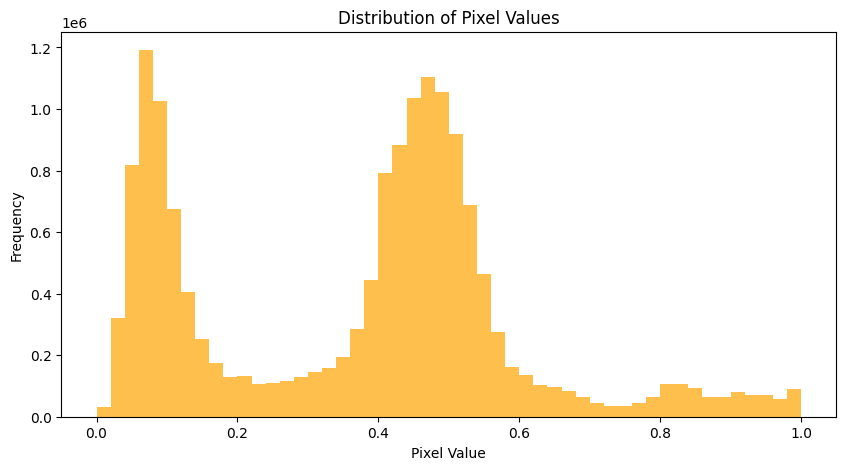

In [10]:
def visualize_image_distribution(images):
    plt.figure(figsize=(10, 5))
    plt.hist(images.ravel(), bins=50, color='orange', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Pixel Values')
    plt.show()

visualize_image_distribution(images)

# Augmented Images

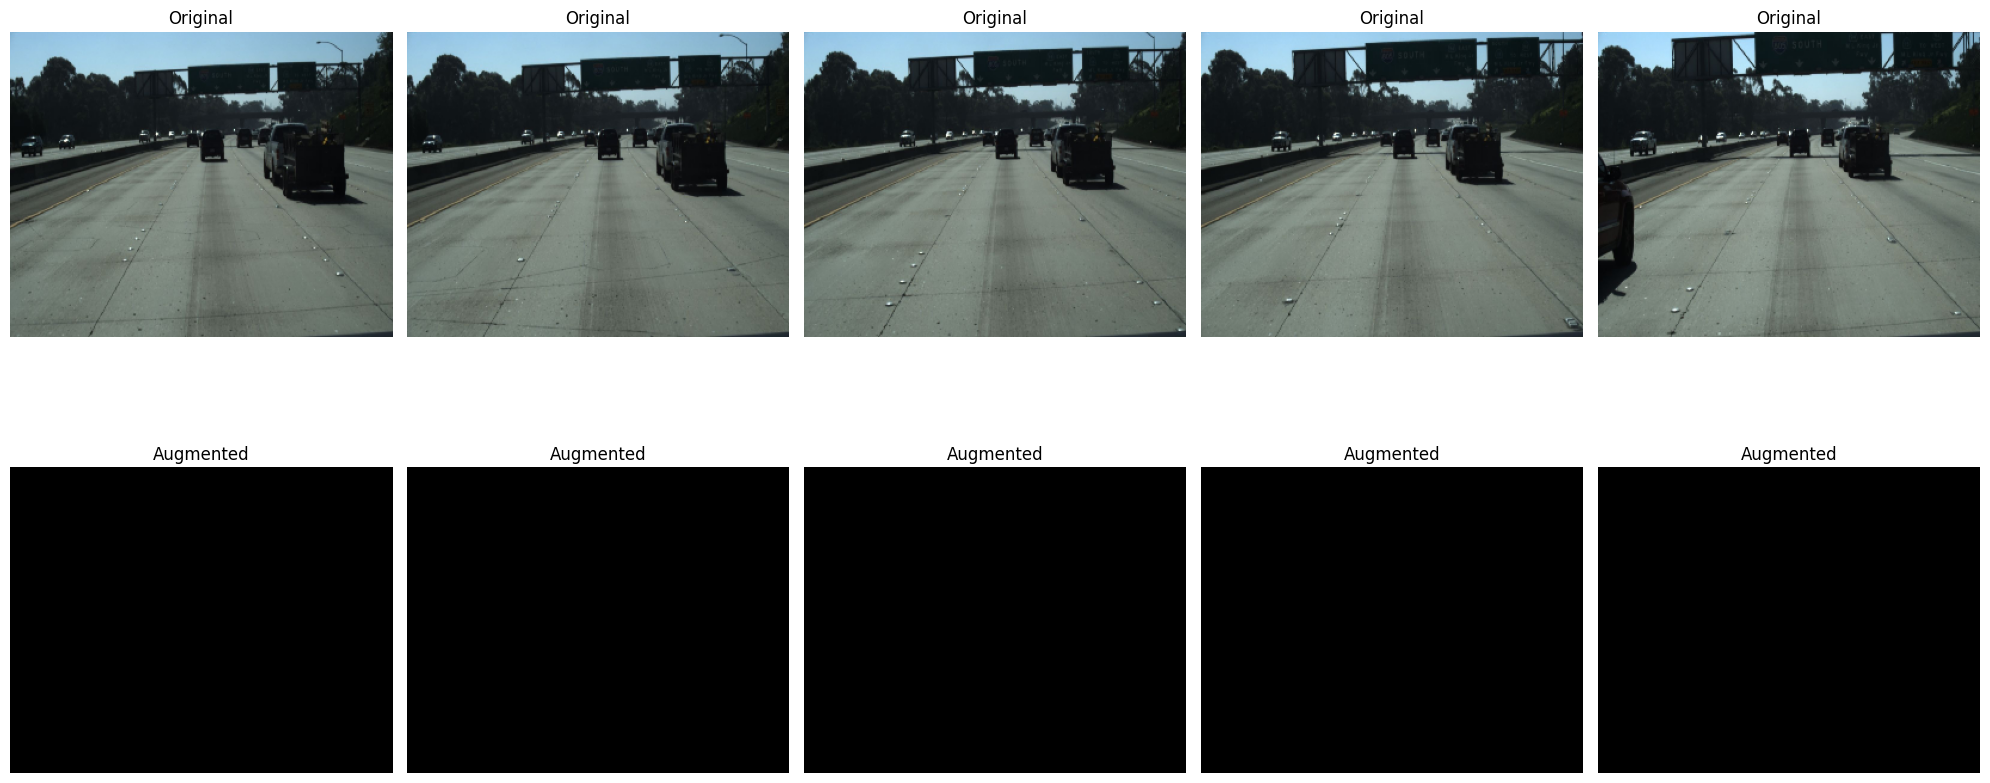

In [11]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def display_augmented_images(images, datagen, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))
    for i in range(num_images):
        img = images[i]
        img = np.expand_dims(img, axis=0)
        aug_iter = datagen.flow(img)
        aug_img = next(aug_iter)[0].astype('uint8')
        axes[0, i].imshow(images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        axes[1, i].imshow(aug_img)
        axes[1, i].axis('off')
        axes[1, i].set_title('Augmented')
    plt.tight_layout()
    plt.show()

display_augmented_images(images, datagen)

# Preprocessing

In [12]:
images, labels = next(images_set)


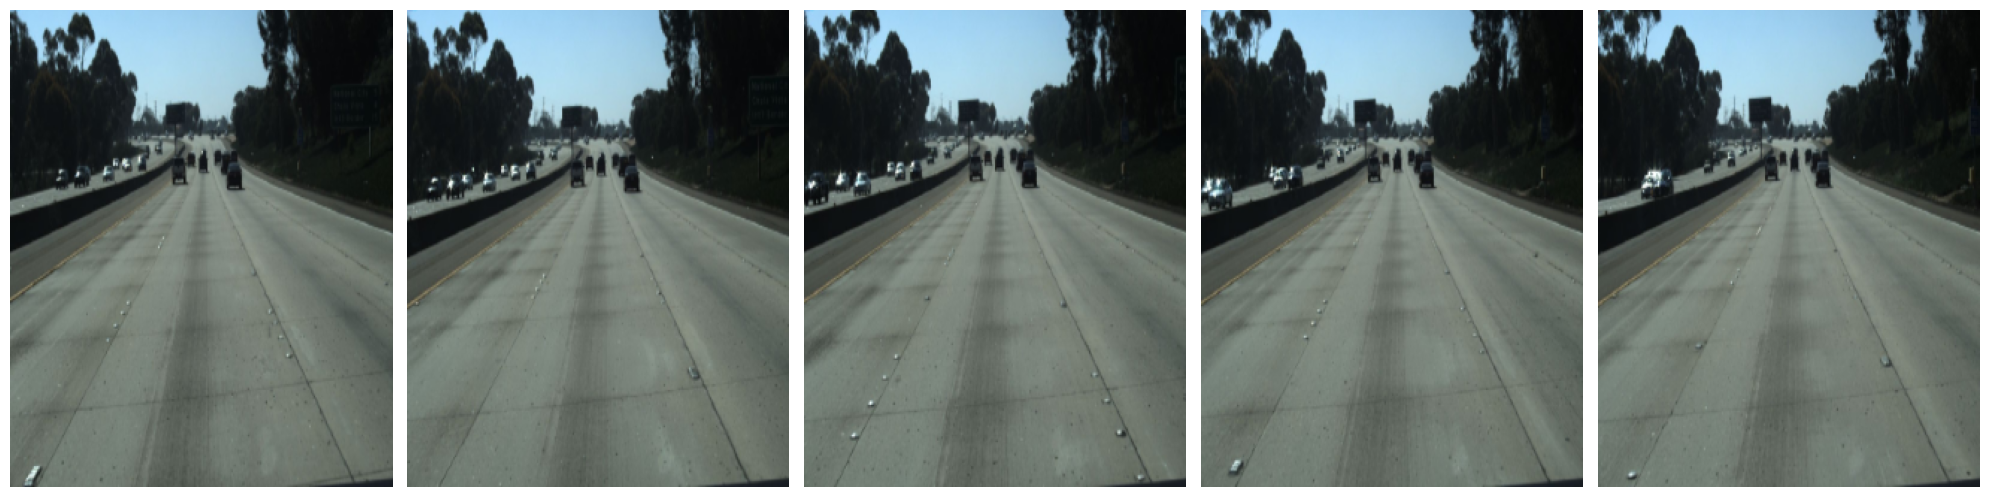

In [13]:
def preprocess_images(images):
    processed_images = []
    for image in images:
        # Resize image to target size
        image = cv2.resize(image, (256, 320))
        # Normalize image to [0, 1]
        image = image / 255.0
        processed_images.append(image)
    return np.array(processed_images)

processed_images = preprocess_images(images)

def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(processed_images[:5])

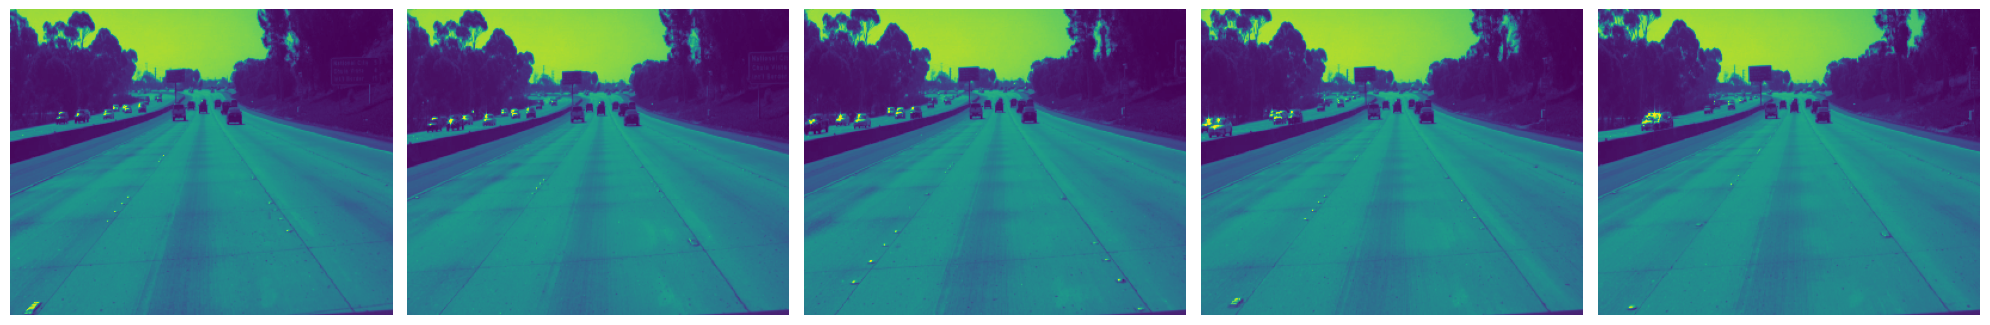

In [14]:
#  CONVERT TO GRAY SCALE

def convert_to_grayscale(images):
    grayscale_images = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(gray_image)
    return np.array(grayscale_images)

grayscale_images = convert_to_grayscale(images)
plot_images(grayscale_images[:5])


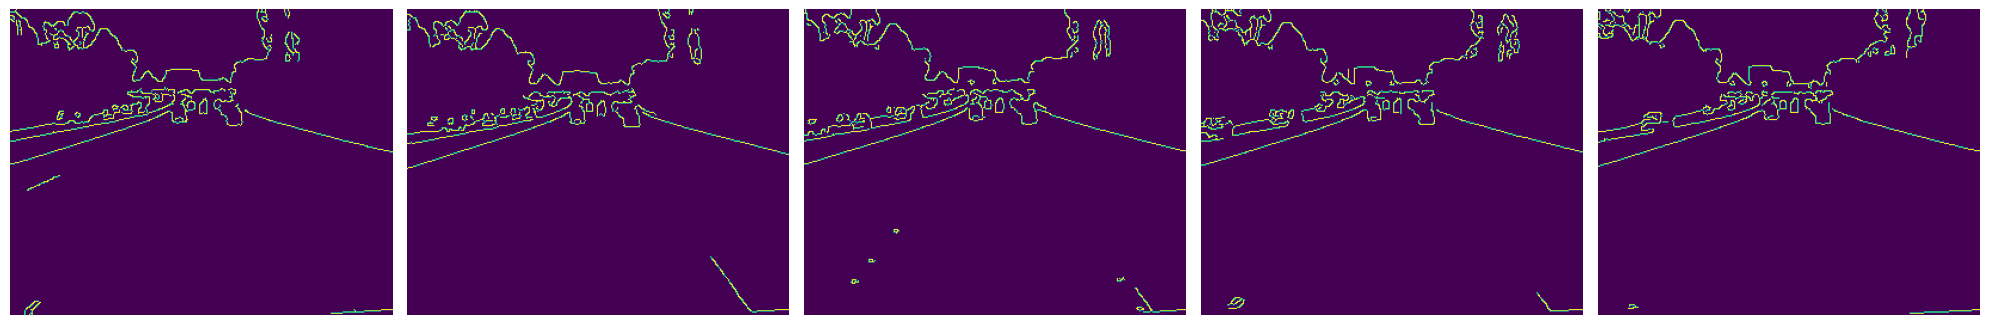

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_gaussian_canny(images):
    canny_images = []
    for image in images:
        image = (image * 255).astype(np.uint8)
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        canny_image = cv2.Canny(blurred_image, 100, 200)
        canny_images.append(canny_image)
    return np.array(canny_images)

canny_images = apply_gaussian_canny(images)
plot_images(canny_images[:5])

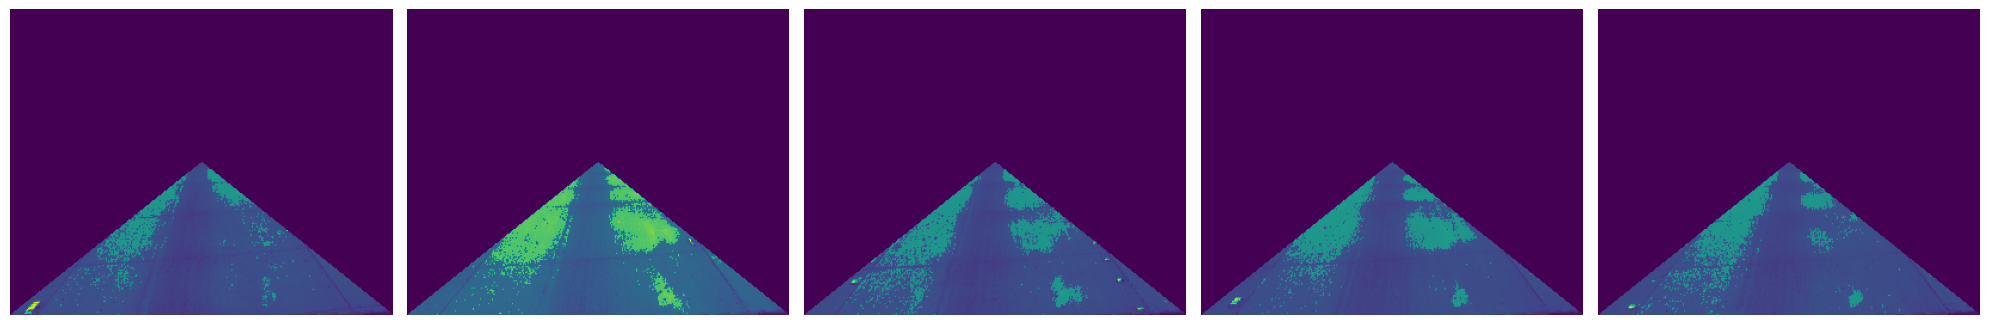

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def convert_to_grayscale(images):
    grayscale_images = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(gray_image)
    return np.array(grayscale_images)

height, width = images[0].shape[:2]
vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)

grayscale_images = convert_to_grayscale(images)

roi_images = []
for image in grayscale_images:
    roi_image = region_of_interest(image, vertices)
    roi_images.append(roi_image)
roi_images = np.array(roi_images)

# Plot the ROI images
plot_images(roi_images[:5])

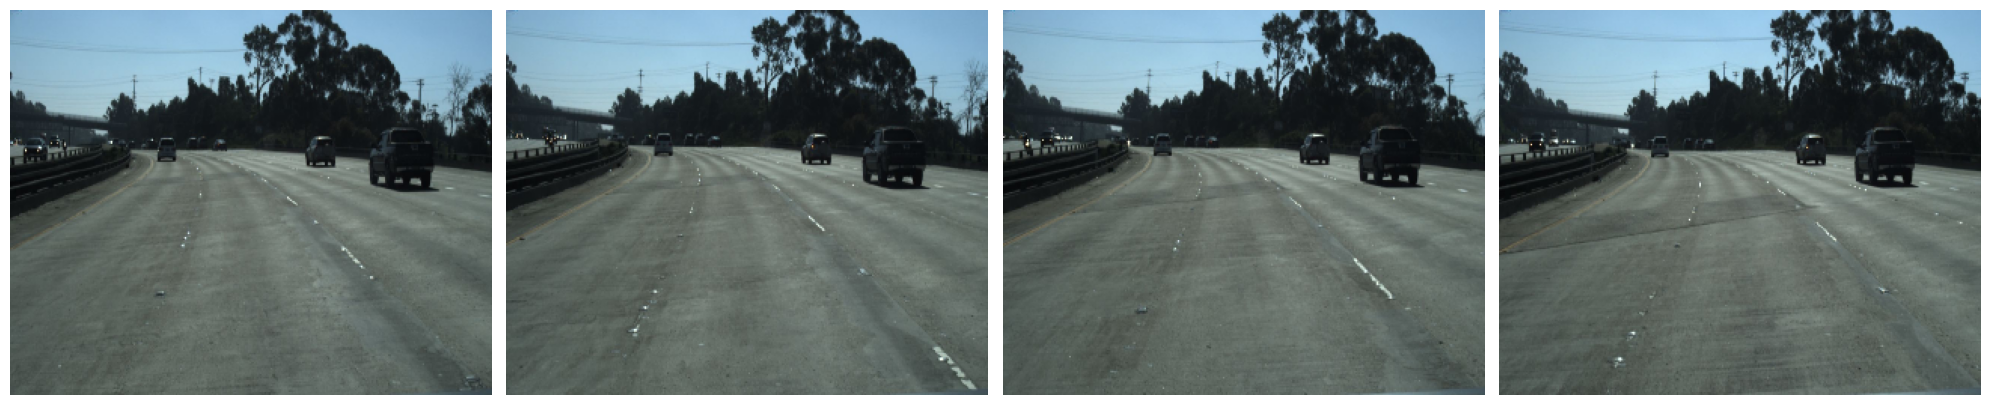

In [17]:
# images list from train
images, labels = next(images_set)
# Normalize images
if images.max() > 1.0:
    images = images / 255.0

# show 4 images
plot_images(images[:4])



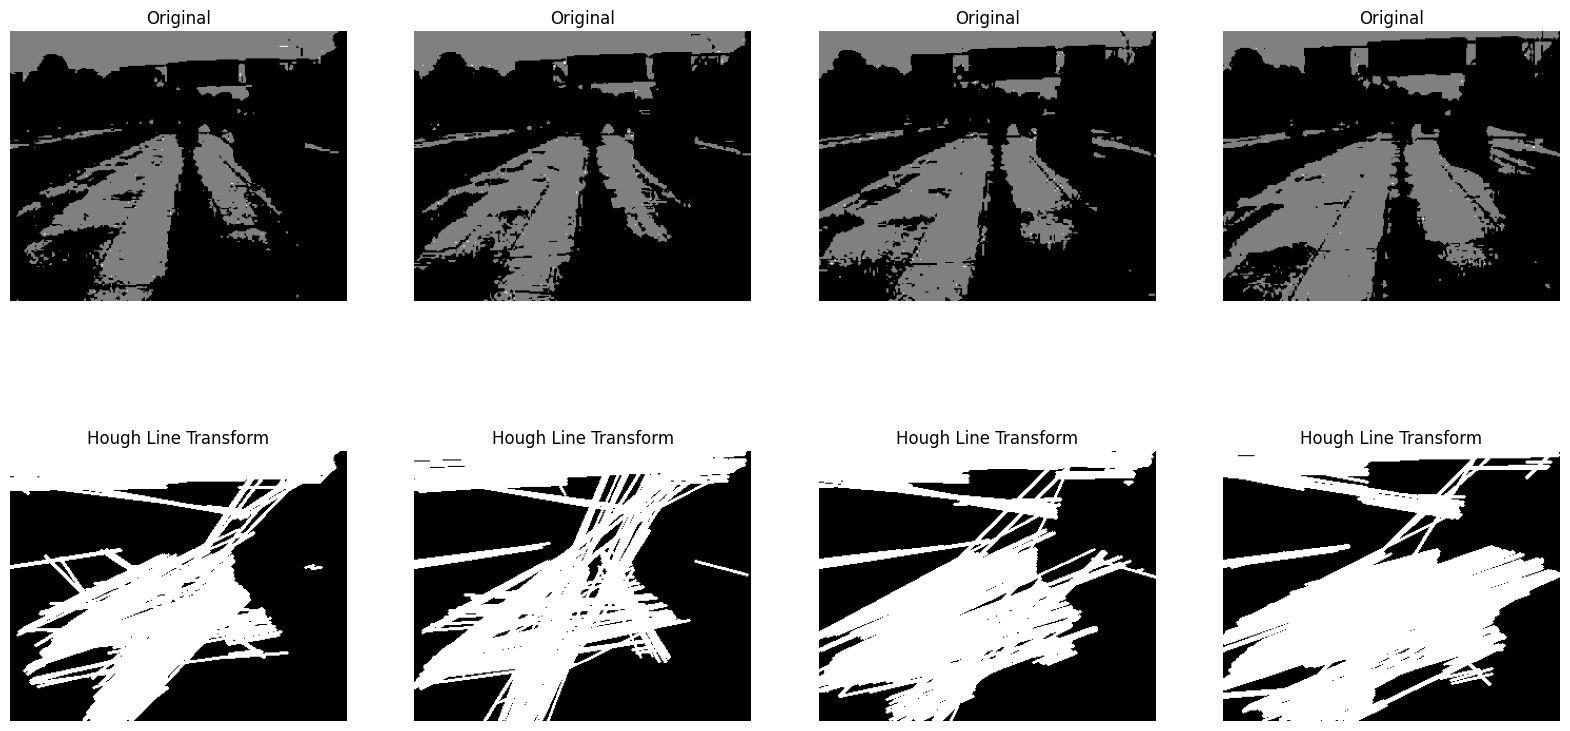

In [ ]:
# Hough Line Transform on the images in the image directory

def apply_hough_line_transform(images):
    hough_images = []
    for image in images:
        lines = cv2.HoughLinesP(image, 1, np.pi / 180, 50, maxLineGap=50)
        hough_image = np.zeros_like(image)
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(hough_image, (x1, y1), (x2, y2), 255, 2)
        hough_images.append(hough_image)
    return np.array(hough_images)

# Read the images from the image directory
images = []
for i in range(4):
    image = cv2.imread(image_dir + f'/image_{i}.jpg')
    images.append(image)
images = np.array(images)

# Convert the images to grayscale
grayscale_images = convert_to_grayscale(images)

# Apply the Hough Line Transform
hough_images = apply_hough_line_transform(grayscale_images)

# Plot the original and Hough Line Transform 
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i in range(4):
    axes[0, i].imshow(grayscale_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')
    axes[1, i].imshow(hough_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Hough Line Transform')
